In [1]:
#!pip uninstall tensorflow -y
#!pip install tensorflow
#!pip uninstall keras -y
#!pip install keras
!pip install keras-rl2

     |████████████████████████████████| 51kB 2.3MB/s 
     |████████████████████████████████| 87.9MB 69kB/s 
     |████████████████████████████████| 501kB 45.2MB/s 
     |████████████████████████████████| 3.1MB 45.5MB/s 
  Created wheel for keras-rl2: filename=keras_rl2-1.0.3-cp36-none-any.whl size=52852 sha256=53322bf17989a7ad323fdcfc47789c0f34848d8ccbc555569ce7f550a5d12d38
  Stored in directory: /root/.cache/pip/wheels/75/70/d7/65d0ca0a87c24f988435973065ef7ddf78af43a603a035aac0
Successfully built keras-rl2
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [0]:
import numpy as np
import gym
from gym import spaces

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import time

from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import GreedyQPolicy, EpsGreedyQPolicy, BoltzmannQPolicy, MaxBoltzmannQPolicy, BoltzmannGumbelQPolicy
from keras.callbacks.callbacks import LambdaCallback

In [0]:
def cria_modelo(n_parametros, n_acoes, input_shape, janela_aprendizado):

    rna = models.Sequential()
    rna.add(layers.Flatten(input_shape=(janela_aprendizado,) + input_shape))
    #rna.add(layers.Dense(128,activation='relu'))
    rna.add(layers.Dense(64,activation='relu'))
    rna.add(layers.Dense(64,activation='relu'))
    rna.add(layers.Dense(32,activation='relu'))
    rna.add(layers.Dense(n_acoes, activation='softmax'))

    #adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
    adam = optimizers.Adam()

    rna.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    #rna.summary()

    return rna

In [0]:
class JogoDaVelhaEnv(gym.Env):
    def __init__(self, teste=False):
        self.campo = None
        self.n_acoes = 9
        self.n_parametros = 9
        self.action_space = spaces.Discrete(self.n_acoes)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.n_acoes,), dtype=np.int8)
        self.teste = teste
        self.reset()

    def observacao(self):
        obs = np.empty(self.n_acoes, dtype=np.int8)
        for i in range(self.n_acoes):
            obs[i] = self.campo[i]
        return obs

    def jogada_oponente(self):
        valido = False
        while not valido:
            jogada = np.random.choice(self.n_acoes)
            if self.campo[jogada] == 0:
                self.campo[jogada] = -1
                valido = True

    def acabou(self):

        acabou = False
        valor = 0
        
        for i in range(3):
            if self.campo[0 + (i * 3)] + self.campo[1 + (i * 3)] + self.campo[2 + (i * 3)] in [3, -3]: #confere as linhas
                valor = self.campo[0 + i] + self.campo[1 + i] + self.campo[2 + i]
            if self.campo[0 + i] + self.campo[3 + i] + self.campo[6 + i] in [3, -3]: #confere as colunas
                valor = self.campo[0 + i] + self.campo[3 + i] + self.campo[6 + i]
            
        if self.campo[0] + self.campo[4] + self.campo[8] in [3, -3]:
            valor = self.campo[0] + self.campo[4] + self.campo[8]
        if self.campo[2] + self.campo[4] + self.campo[6] in [3, -3]:
            valor = self.campo[2] + self.campo[4] + self.campo[6]

        valor = int(valor / 3)
        if valor != 0:
            acabou = True
        else:
            acabou = True
            for i in range(9):
                if self.campo[i] == 0:
                    acabou = False

        return [acabou, valor]

    def step(self, acao):

        recompensa = None
        valido = None

        if self.campo[acao] == 0:
            self.campo[acao] = 1
            valido = True
            acabou = self.acabou()
            if acabou[0] and acabou[1] == 1:
                recompensa = 100
            elif acabou[0] and acabou[1] == 0:
                #recompensa = -20
                recompensa = 0
            else:
                #recompensa = 20
                recompensa = 0
        else:
            recompensa = -20
            valido = False

        if valido and not self.acabou()[0]:
            self.jogada_oponente()
            acabou = self.acabou()
            if acabou[0]:
                recompensa = -100

        #return self.observacao(), recompensa, self.acabou()[0], {'teste':10}
        return self.observacao(), recompensa, self.acabou()[0], {}

    def reset(self):
        self.campo = np.zeros(self.n_parametros)
        comeca = bool(np.random.choice(2))
        if not self.teste and not comeca:
            self.jogada_oponente()
        return self.observacao()

    def render(self):
        #print(self.observacao())
        #time.sleep(1)
        pass

In [0]:
from rl.policy import Policy

class MaxBoltzmannQPolicyEpsDecay(Policy):
    def __init__(self, eps=.1, tau=1., clip=(-500., 500.), n_episodios):
        super(MaxBoltzmannQPolicy, self).__init__()
        self.eps = eps
        self.tau = tau
        self.clip = clip
        self.n_episodios = n_episodios
        self.episodio = 

    def select_action(self, q_values):
        assert q_values.ndim == 1
        q_values = q_values.astype('float64')
        nb_actions = q_values.shape[0]

        if np.random.uniform() < self.eps:
            exp_values = np.exp(np.clip(q_values / self.tau, self.clip[0], self.clip[1]))
            probs = exp_values / np.sum(exp_values)
            action = np.random.choice(range(nb_actions), p=probs)
        else:
            action = np.argmax(q_values)
        return action

    def get_config(self):
        config = super(MaxBoltzmannQPolicy, self).get_config()
        config['eps'] = self.eps
        config['tau'] = self.tau
        config['clip'] = self.clip
        return config

In [224]:
ambiente = JogoDaVelhaEnv() #cria o ambiente para o jogo
n_parametros = ambiente.n_parametros #define o numero de entradas da rede
n_acoes = ambiente.n_acoes #define o numero de saidas da rede
input_shape = ambiente.observation_space.shape
janela_aprendizado = 1 #quantas linhas da memoria vai pegar pra treinar o modelo por vez
n_steps = 100000

memoria = SequentialMemory(limit=10000, window_length=janela_aprendizado)
modelo = cria_modelo( 9, 9, input_shape, janela_aprendizado )
#politica = MaxBoltzmannQPolicy( eps=0.5, tau=1.5 ) #tau grande -> Aleatorio, tau pequeno -> Greedy
politica = EpsGreedyQPolicy( eps=0.2 )
agente = DQNAgent( model=modelo, policy=politica, nb_actions=n_acoes, memory=memoria, enable_double_dqn=True, test_policy=GreedyQPolicy() )
#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
agente.compile(optimizers.Adam(), metrics=['mae'])

historia_treino = []
batch_print_callback_treino = LambdaCallback(on_batch_end=lambda batch,logs: historia_treino.append(logs))

agente.fit(env=ambiente, nb_steps=n_steps, visualize=False, verbose=1, callbacks=[batch_print_callback_treino])

agente.save_weights('dqn_pre_teste.h5f', overwrite=True)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 66s 7ms/step - reward: -16.2600
436 episodes - episode_reward: -368.716 [-4340.000, 100.000] - loss: 344.631 - mae: 2.385 - mean_q: 0.885

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 72s 7ms/step - reward: -9.5680
830 episodes - episode_reward: -117.229 [-5000.000, 100.000] - loss: 433.543 - mae: 2.441 - mean_q: 0.933

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 75s 8ms/step - reward: -3.4300
1312 episodes - episode_reward: -26.311 [-3160.000, 100.000] - loss: 665.599 - mae: 2.660 - mean_q: 0.922

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 76s 8ms/step - reward: -1.1940
1455 episodes - episode_reward: -8.206 [-3460.000, 100.000] - loss: 796.679 - mae: 2.788 - mean_q: 0.918

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 77s 8ms/step

In [225]:
agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam(), metrics=['mae'])
agente.load_weights('dqn_pre_teste.h5f')

historia_teste = []
batch_print_callback_teste = LambdaCallback(on_batch_end=lambda batch,logs: historia_teste.append(logs))

agente.fit(env=ambiente, nb_steps=n_steps/10, visualize=False, verbose=1, callbacks=[batch_print_callback_teste])

agente.save_weights('dqn_pos_teste.h5f', overwrite=True)

Training for 10000.0 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 57s 6ms/step - reward: -19.9340
done, took 56.540 seconds


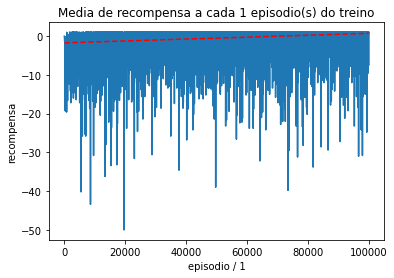

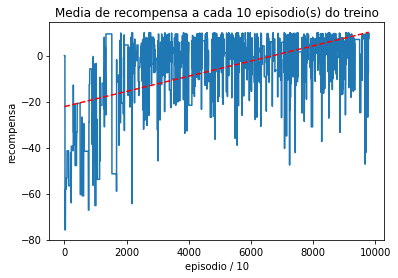

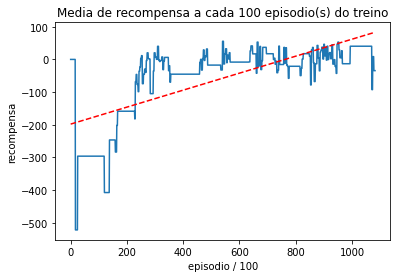

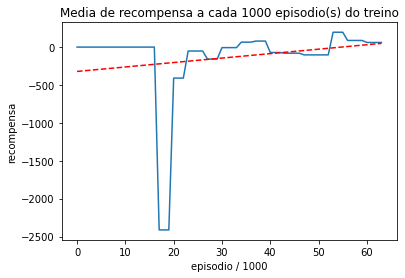

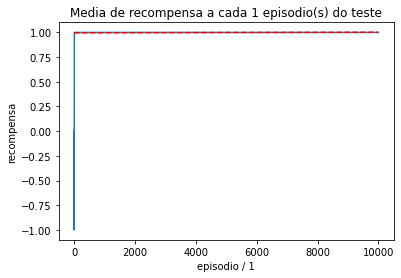

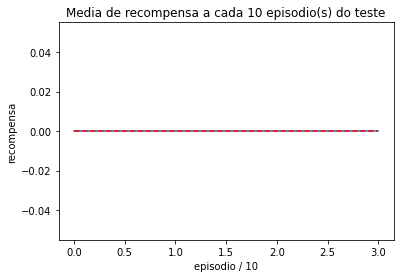

In [226]:
#Treino
divisores = [1, 10, 100, 1000]
for divisor in divisores:
    recompensas = []
    recompensas_media = []
    recompensas_ref = []
    ref = 0
    for i in range(len(historia_treino) + 1):
        if len(recompensas) % divisor == 0:
            recompensas_media.append( sum(recompensas[-divisor:]) / media_por )
        if len(historia_treino) == i or historia_treino[i]['episode'] != ref:
            recompensas.append( round(sum(recompensas_ref), 1) )
            ref += 1
            recompensas_ref = []
        if len(historia_treino) != i:
            recompensas_ref.append( historia_treino[i]['reward'] )

    x_plot = np.arange(len(recompensas_media))

    #plota grafico
    plt.title('Media de recompensa a cada {} episodio(s) do treino'.format(divisor))
    plt.xlabel('episodio / {}'.format(divisor))
    plt.ylabel('recompensa')
    plt.plot(x_plot, recompensas_media)
    #linha de tendencia
    z = np.polyfit(x_plot, recompensas_media, 1)
    p = np.poly1d(z)
    plt.plot(x_plot,p(x_plot),"r--")
    plt.show()



#Teste
divisores = [1, 10]
for divisor in divisores:
    recompensas = []
    recompensas_media = []
    recompensas_ref = []
    ref = 0
    for i in range(len(historia_teste) + 1):
        if len(recompensas) % divisor == 0:
            recompensas_media.append( sum(recompensas[-divisor:]) / media_por )
        if len(historia_teste) == i or historia_teste[i]['episode'] != ref:
            recompensas.append( round(sum(recompensas_ref), 1) )
            ref += 1
            recompensas_ref = []
        if len(historia_teste) != i:
            recompensas_ref.append( historia_teste[i]['reward'] )

    x_plot = np.arange(len(recompensas_media))

    #plota grafico
    plt.title('Media de recompensa a cada {} episodio(s) do teste'.format(divisor))
    plt.xlabel('episodio / {}'.format(divisor))
    plt.ylabel('recompensa')
    plt.plot(x_plot, recompensas_media)
    #linha de tendencia
    z = np.polyfit(x_plot, recompensas_media, 1)
    p = np.poly1d(z)
    plt.plot(x_plot,p(x_plot),"r--")
    plt.show()

In [230]:
def jogada_agente(agente, estado):
    estado_reshape = [estado]
    saida = agente.compute_q_values( estado_reshape )
    jogada = np.argmax( saida )
    return jogada

def printa_campo(estado, simbolo_jogador):
    for i in range(len(estado)):
        if( i ) % 3 == 0:
            print()
        else:
            print('| ', end='')
        simbolo_maquina = 'O'
        if simbolo_jogador == 'O':
            simbolo_maquina = 'X'
        if estado[i] == -1:
            print(simbolo_jogador + ' ', end='')
        elif estado[i] == 1:
            print(simbolo_maquina + ' ', end='')
        else:
            print('- ', end='')
    print()

#jogar contra a maquina
ambiente = JogoDaVelhaEnv( teste=True ) #cria o ambiente para o jogo
agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam())
agente.load_weights('dqn_pre_teste.h5f')

vez_do_jogador = True

while not ambiente.acabou()[0]:
    if vez_do_jogador:
        #jogada do jogador
        jogada_valida = False
        while not jogada_valida:
            jogada = int(input('campo a jogar: '))
            if ambiente.campo[ jogada ] != 0:
                print('campo inválido')
            else:
                ambiente.campo[ jogada ] = -1
                jogada_valida = True

    else:
        #jogada da maquina
        jogada_valida = False
        contagem = 0
        while not jogada_valida:
            jogada = jogada_agente( agente, ambiente.observacao() )
            if ambiente.campo[ jogada ] == 0:
                ambiente.campo[ jogada ] = 1
                jogada_valida = True
            contagem += 1
            if contagem == 10:
                break
    
    vez_do_jogador = not vez_do_jogador
    printa_campo( ambiente.observacao(), 'X' )

resultado = ambiente.acabou()[1]
ganhador = None #define uma variavel para quem ganhou o jogo
if resultado == -1: #se o resultado for 1
    ganhador = 'Voce ganhou' #o ganhador foi a IA
elif resultado == 1: #se o resultado for -1
    ganhador = 'A IA ganhou' #o ganhador foi o oponente aleatorio
else: #se o resultado for 0
    ganhador = 'Deu velha' #o jogo deu velha

print(ganhador)

campo a jogar: 1

- | X | - 
- | - | - 
- | - | - 

- | X | - 
- | O | - 
- | - | - 
campo a jogar: 2

- | X | X 
- | O | - 
- | - | - 

O | X | X 
- | O | - 
- | - | - 
campo a jogar: 7

O | X | X 
- | O | - 
- | X | - 

O | X | X 
- | O | - 
- | X | O 
A IA ganhou
